# Time Series Models

In [25]:
import yfinance as yf
import pandas as pd

from tqdm import tqdm

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
# automatically estimate differencing term
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [26]:
data = pd.read_csv("../raw_data/raw_data_stock_market_4y_fortimeseries.csv")
data

,Date,A,AA,AACG,AACI,AACIW,AACT,AADI,AAGR,AAGRW,...,ZUMZ,ZUO,ZURA,ZURAW,ZVIA,ZVRA,ZVSA,ZWS,ZYME,ZYXI
0,2019-06-03 00:00:00-04:00,64.663116,20.927528,1.80,NaN,NaN,NaN,15.600,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-06-04 00:00:00-04:00,65.589783,21.297235,1.83,NaN,NaN,NaN,15.600,NaN,NaN,...,20.650000,14.30,NaN,NaN,NaN,24.799999,NaN,27.959999,19.080000,6.636364
2,2019-06-05 00:00:00-04:00,65.975883,20.791321,1.84,NaN,NaN,NaN,15.000,NaN,NaN,...,19.940001,14.18,NaN,NaN,NaN,24.000000,NaN,28.120001,19.610001,7.245455
3,2019-06-06 00:00:00-04:00,66.757751,20.985899,1.99,NaN,NaN,NaN,15.000,NaN,NaN,...,18.670000,14.57,NaN,NaN,NaN,23.520000,NaN,28.120001,19.990000,7.690909
4,2019-06-07 00:00:00-04:00,67.105247,20.859425,1.99,NaN,NaN,NaN,15.000,NaN,NaN,...,21.650000,14.56,NaN,NaN,NaN,22.559999,NaN,28.110001,20.930000,7.918182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,2024-05-24 00:00:00-04:00,150.660004,41.639999,0.85,11.460,NaN,NaN,1.840,0.378,NaN,...,18.400000,9.97,NaN,NaN,0.950,4.660000,4.310,31.950001,8.720000,10.520000
1255,2024-05-28 00:00:00-04:00,148.210007,43.200001,0.84,11.370,NaN,NaN,1.880,0.399,NaN,...,18.940001,9.57,NaN,NaN,0.908,4.560000,4.254,31.290001,8.710000,10.110000
1256,2024-05-29 00:00:00-04:00,145.479996,43.930000,0.85,11.364,NaN,NaN,1.760,0.400,NaN,...,19.049999,9.72,NaN,NaN,0.890,4.595000,4.266,30.459999,8.480000,10.020000
1257,2024-05-30 00:00:00-04:00,131.419998,44.540001,0.90,11.490,NaN,NaN,1.735,0.383,NaN,...,18.950001,9.71,NaN,NaN,0.823,4.670000,4.080,31.080000,8.430000,9.920000


In [27]:
#Imports
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer

#CLEANING THE DATA:

#drop columns that have more than 30% of missing data:
def remove_shitty_columns(df):
    for column in df.columns:
        if df[column].isnull().sum()/len(df) > 0.01:
            df.drop(columns=[column], inplace=True)
    return df


#drop rows that have more than 30% of missing values
def remove_shitty_rows(df):
    threshold = 0.3 * df.shape[1]  # Calculate the threshold for missing values
    df = df.dropna(thresh=int(df.shape[1] - threshold))
    return df

#FINAL CLEANING FUNCTION
def clean_dataframe(df):
    df = remove_shitty_columns(df)
    df = remove_shitty_rows(df)
    df = df.reset_index(drop=True)
    return df


#PREPROCESSING
def preprocessing_the_data(df):
    #use simple impute with strategy = "constant"
    imputer = SimpleImputer(strategy="constant", fill_value=0)

    #Robust Scaler to Scale data because of outliers
    rb_scaler = RobustScaler()

    #select numerical columns
    num_transformer = make_pipeline(imputer, rb_scaler)
    num_columns = make_column_selector(dtype_exclude="object")

    #Create Preproc Pipeline
    preproc_basic = make_column_transformer((num_transformer, num_columns))

    #Apply Preprocessing to dataframe
    preprocessed_data = preproc_basic.fit_transform(df)

    #Change column names of transformed dataframe
    df_preproc = pd.DataFrame(preprocessed_data, columns=preproc_basic.get_feature_names_out())

    #Merge with tickers
    df_preproc = df_preproc.join(df.Ticker)

    return df_preproc


In [28]:
# We define here a "Plot forecast vs. real", which also shows historical training set

def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None

    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

In [29]:
data_clean = remove_shitty_columns(data)
data_clean

,Date,A,AA,AACG,AADI,AAL,AAME,AAOI,AAON,AAP,...,ZTEK,ZTO,ZTR,ZTS,ZUMZ,ZUO,ZVRA,ZWS,ZYME,ZYXI
0,2019-06-03 00:00:00-04:00,64.663116,20.927528,1.80,15.600,26.917612,2.298342,8.81,29.745047,140.279739,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-06-04 00:00:00-04:00,65.589783,21.297235,1.83,15.600,28.817680,2.298342,9.19,31.003340,141.598557,...,0.27,17.606050,8.710528,106.453125,20.650000,14.30,24.799999,27.959999,19.080000,6.636364
2,2019-06-05 00:00:00-04:00,65.975883,20.791321,1.84,15.000,30.044806,2.298342,9.23,31.184948,141.598557,...,0.28,17.066587,8.702794,106.827278,19.940001,14.18,24.000000,28.120001,19.610001,7.245455
3,2019-06-06 00:00:00-04:00,66.757751,20.985899,1.99,15.000,30.064596,2.375923,9.30,31.249809,141.864120,...,0.28,16.939081,8.741472,107.211266,18.670000,14.57,23.520000,28.120001,19.990000,7.690909
4,2019-06-07 00:00:00-04:00,67.105247,20.859425,1.99,15.000,30.598991,2.375923,9.50,31.684376,142.276260,...,0.26,17.223522,8.803359,108.363228,21.650000,14.56,22.559999,28.110001,20.930000,7.918182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,2024-05-24 00:00:00-04:00,150.660004,41.639999,0.85,1.840,13.840000,1.650000,12.54,78.260002,69.570000,...,1.08,24.080000,5.400000,170.070007,18.400000,9.97,4.660000,31.950001,8.720000,10.520000
1255,2024-05-28 00:00:00-04:00,148.210007,43.200001,0.84,1.880,13.440000,1.630000,12.38,77.680000,70.180000,...,1.10,24.660000,5.350000,171.300003,18.940001,9.57,4.560000,31.290001,8.710000,10.110000
1256,2024-05-29 00:00:00-04:00,145.479996,43.930000,0.85,1.760,11.620000,1.640000,11.98,74.870003,62.480000,...,1.11,24.049999,5.270000,170.800003,19.049999,9.72,4.595000,30.459999,8.480000,10.020000
1257,2024-05-30 00:00:00-04:00,131.419998,44.540001,0.90,1.735,11.440000,1.660000,11.59,74.930000,66.959999,...,1.11,23.860001,5.340000,169.440002,18.950001,9.71,4.670000,31.080000,8.430000,9.920000


In [30]:
data_clean['Date'] = pd.to_datetime(data_clean['Date'], utc=True)
data_clean = data_clean.set_index("Date")
data_clean.index= data_clean.index.tz_localize(None)
data_clean

,A,AA,AACG,AADI,AAL,AAME,AAOI,AAON,AAP,AAPL,...,ZTEK,ZTO,ZTR,ZTS,ZUMZ,ZUO,ZVRA,ZWS,ZYME,ZYXI
Date,,,,,,,,,,,,,,,,,,,,,
2019-06-03 04:00:00,64.663116,20.927528,1.80,15.600,26.917612,2.298342,8.81,29.745047,140.279739,41.812832,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-06-04 04:00:00,65.589783,21.297235,1.83,15.600,28.817680,2.298342,9.19,31.003340,141.598557,43.342518,...,0.27,17.606050,8.710528,106.453125,20.650000,14.30,24.799999,27.959999,19.080000,6.636364
2019-06-05 04:00:00,65.975883,20.791321,1.84,15.000,30.044806,2.298342,9.23,31.184948,141.598557,44.042210,...,0.28,17.066587,8.702794,106.827278,19.940001,14.18,24.000000,28.120001,19.610001,7.245455
2019-06-06 04:00:00,66.757751,20.985899,1.99,15.000,30.064596,2.375923,9.30,31.249809,141.864120,44.688828,...,0.28,16.939081,8.741472,107.211266,18.670000,14.57,23.520000,28.120001,19.990000,7.690909
2019-06-07 04:00:00,67.105247,20.859425,1.99,15.000,30.598991,2.375923,9.50,31.684376,142.276260,45.878311,...,0.26,17.223522,8.803359,108.363228,21.650000,14.56,22.559999,28.110001,20.930000,7.918182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-24 04:00:00,150.660004,41.639999,0.85,1.840,13.840000,1.650000,12.54,78.260002,69.570000,189.979996,...,1.08,24.080000,5.400000,170.070007,18.400000,9.97,4.660000,31.950001,8.720000,10.520000
2024-05-28 04:00:00,148.210007,43.200001,0.84,1.880,13.440000,1.630000,12.38,77.680000,70.180000,189.990005,...,1.10,24.660000,5.350000,171.300003,18.940001,9.57,4.560000,31.290001,8.710000,10.110000
2024-05-29 04:00:00,145.479996,43.930000,0.85,1.760,11.620000,1.640000,11.98,74.870003,62.480000,190.289993,...,1.11,24.049999,5.270000,170.800003,19.049999,9.72,4.595000,30.459999,8.480000,10.020000


In [31]:
data_clean["GOOG"]

Date
2019-06-03 04:00:00           NaN
2019-06-04 04:00:00     52.652500
2019-06-05 04:00:00     52.111000
2019-06-06 04:00:00     52.216999
2019-06-07 04:00:00     53.301998
                          ...    
2024-05-24 04:00:00    176.330002
2024-05-28 04:00:00    178.020004
2024-05-29 04:00:00    177.399994
2024-05-30 04:00:00    173.559998
2024-05-31 04:00:00    173.960007
Name: GOOG, Length: 1259, dtype: float64

In [32]:
type(data_clean.index)

pandas.core.indexes.datetimes.DatetimeIndex

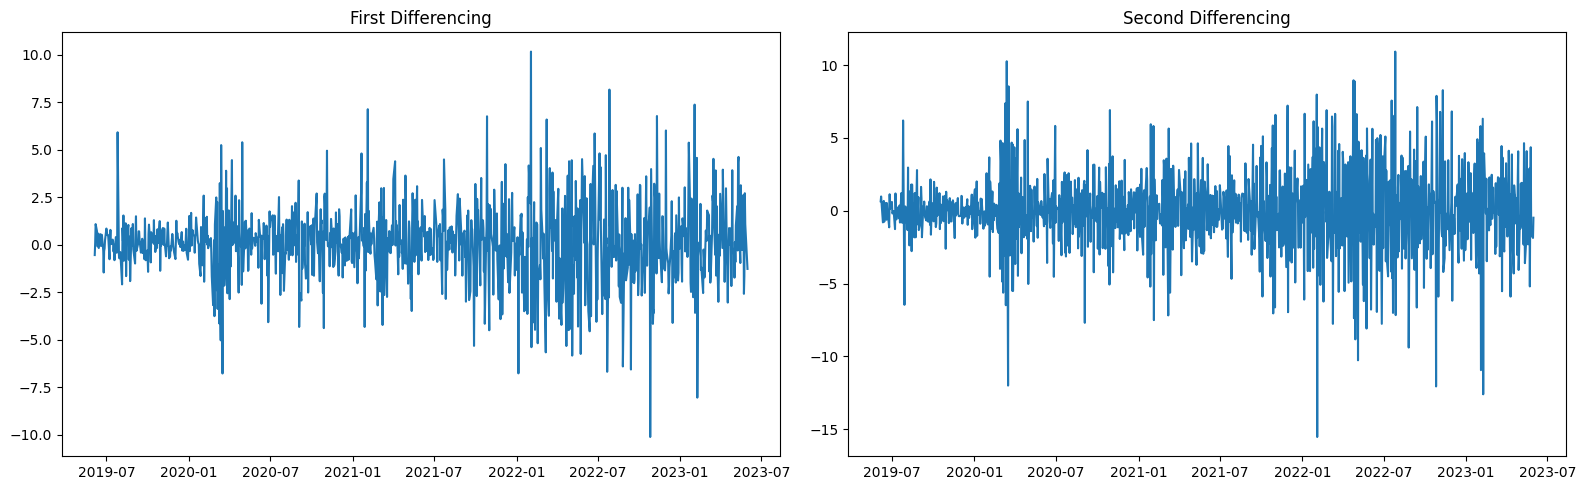

p-value zero-diff:  0.5259782117046883
p-value first-diff:  0.0
p-value second-diff:  2.03807404221956e-25


In [33]:
tmp_df = pd.DataFrame(data_clean["GOOG"])

train_size = 0.8
index = round(train_size*tmp_df.shape[0])

df_train = tmp_df.iloc[:index]
df_test = tmp_df.iloc[index:]

#Differencing:
diff_1 = df_train.diff()
diff_2 = diff_1.diff()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot the first differencing on the first axis
axes[0].plot(diff_1)
axes[0].set_title('First Differencing')

# Plot the second differencing on the second axis
axes[1].plot(diff_2)
axes[1].set_title('Second Differencing')

# Display the plots
plt.tight_layout()
plt.show()

# check with ADF Test for stationarity
print('p-value zero-diff: ', adfuller(df_train.dropna())[1])
print('p-value first-diff: ', adfuller(df_train.diff().dropna())[1])
print('p-value second-diff: ', adfuller(df_train.diff().diff().dropna())[1])

### diff 1 oder diff 2 ? -> change next cell!

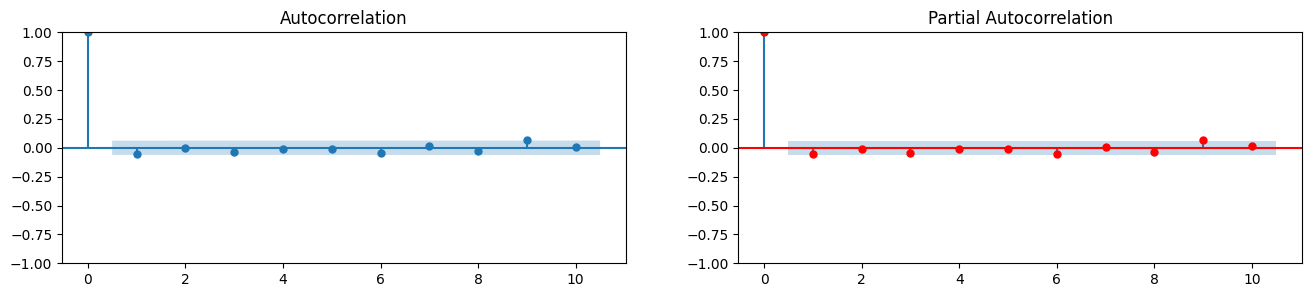

In [34]:
#Plot ACF and PACF
fig, axes = plt.subplots(1,2, figsize=(16,3))

plot_acf(diff_1.dropna(), lags=10, ax=axes[0]);
plot_pacf(diff_1.dropna(), lags=10, ax=axes[1], color='r');

In [35]:
arima = ARIMA(df_train, order=(0, 1, 0), trend='t')
arima = arima.fit()
arima.summary()

/Users/guillaumegavillet/.pyenv/versions/3.10.6/envs/project_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/guillaumegavillet/.pyenv/versions/3.10.6/envs/project_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/guillaumegavillet/.pyenv/versions/3.10.6/envs/project_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   GOOG   No. Observations:                 1007
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -2136.260
Date:                Tue, 04 Jun 2024   AIC                           4276.520
Time:                        15:33:23   BIC                           4286.347
Sample:                             0   HQIC                          4280.254
                               - 1007                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0704      0.063      1.109      0.267      -0.054       0.195
sigma2         4.0463      0.118     34.293      0.000       3.815       4.278
===================================================================================
Ljung-Box (L1) (Q):                   2.84   Jarque-Bera (JB):               303.36
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):               3.69   Skew:                            -0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [12]:
pickle.dump(arima, open("../project_awesome/model/google_time_series_model.pk1", "wb"))

/Users/guillaumegavillet/.pyenv/versions/3.10.6/envs/project_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/guillaumegavillet/.pyenv/versions/3.10.6/envs/project_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/guillaumegavillet/.pyenv/versions/3.10.6/envs/project_env/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/Users/guillaumegavillet/.pyenv/versions/3.10.6/envs/project_env/l

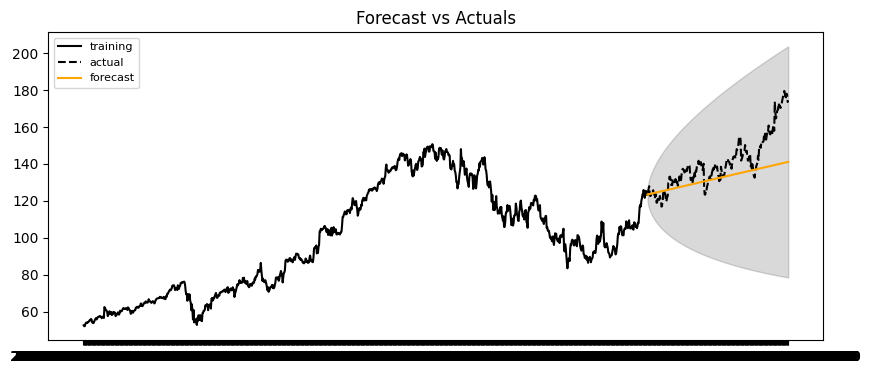

In [39]:
# API 

tmp_df = pd.read_csv("../process_data/Google_data_time_series.csv", index_col="Date")

train_size = 0.8
index = round(train_size*tmp_df.shape[0])

df_train = tmp_df.iloc[:index]
df_test = tmp_df.iloc[index:]

def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None

    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);
    
forecast = arima.forecast(len(df_test), alpha=0.05)  # 95% confidence

# Forecast values and confidence intervals
forecast_results = arima.get_forecast(len(df_test), alpha=0.05)
forecast = forecast_results.predicted_mean
confidence_int = forecast_results.conf_int().values

forecast_df = pd.DataFrame(forecast).set_index(df_test.index)
forecast_df = forecast_df["predicted_mean"]

plot_forecast(forecast_df, df_train, df_test, confidence_int[:,0], confidence_int[:,1])


In [ ]:
tmp_df.to_csv("../process_data/Google_data_time_series.csv")

In [37]:
pd.read_csv("../process_data/Google_data_time_series.csv", index_col="Date")

,GOOG
Date,
2019-06-03 04:00:00,NaN
2019-06-04 04:00:00,52.652500
2019-06-05 04:00:00,52.111000
2019-06-06 04:00:00,52.216999
2019-06-07 04:00:00,53.301998
...,...
2024-05-24 04:00:00,176.330002
2024-05-28 04:00:00,178.020004
2024-05-29 04:00:00,177.399994


In [ ]:
loaded_model = pickle.load(open("../project_awesome/model/google_time_series_model.pk1", "rb"))
loaded_model.summary()